In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
pd.options.display.float_format= '{:.2f}'.format

In [4]:
ticker_names = pd.read_csv(os.path.join('Resources', 'other-listed.csv')).\
rename(columns={'ACT Symbol':'Ticker'}).\
drop(columns=['Security Name', 'Exchange', 'CQS Symbol',
       'ETF', 'Round Lot Size', 'Test Issue', 'NASDAQ Symbol'])

nyse = pd.read_csv(os.path.join('Resources', 'nyse.csv'))
nasdaq = pd.read_csv(os.path.join('Resources', 'nasdaq.csv'))
frames = [nyse, nasdaq]

tickers = pd.concat(frames).sort_values(by='Ticker')

In [5]:
data_2018 = pd.read_csv(os.path.join('Resources', '2018_Financial_Data.csv')).\
rename(columns={'Unnamed: 0':'Ticker'}).\
sort_values(by='Ticker').\
reset_index(drop=True)

df = tickers.merge(data_2018, on='Ticker')

In [8]:
tickers[tickers['Ticker'].str.startswith('SP') == True];

In [127]:
tickers[tickers['Company Name'].str.contains('ETF') == True]

In [90]:
df.head();

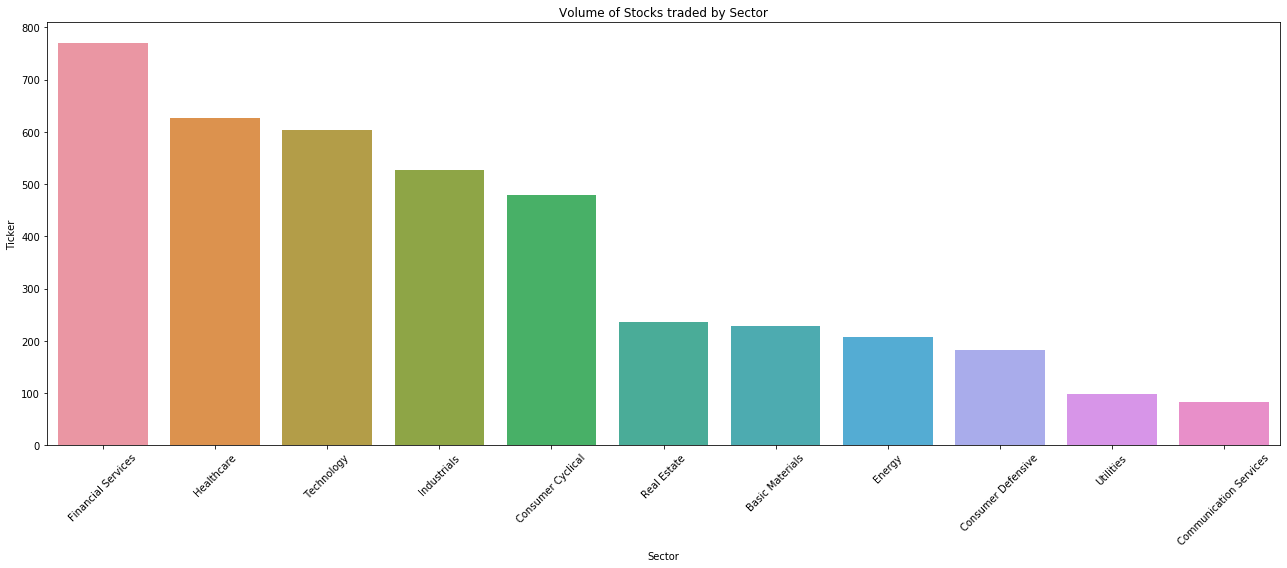

In [130]:
sector_count = pd.DataFrame(df.groupby(['Sector']).count()['Ticker']).reset_index().sort_values(by='Ticker', ascending=False)

plt.figure(figsize=(18,8))
plt.title('Volume of Stocks traded by Sector')
sns.barplot(x = sector_count['Sector'], y = sector_count['Ticker']).set_xticklabels(labels = sector_count['Sector'], rotation=45)
plt.tight_layout()
# plt.savefig(os.path.join('Figures','StockVolume_Sector.png'))

In [131]:
df[df['Sector'] == "Consumer Cyclical"]

,Ticker,Company Name,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class
7,AAP,Advance Auto Parts Inc,9580554000.00,0.02,5361141000.00,4219413000.00,0.00,3615138000.00,3615138000.00,604275000.00,...,0.03,0.05,0.07,0.04,0.00,0.00,0.03,Consumer Cyclical,1.57,1
19,ABG,Asbury Automotive Group Inc,6874400000.00,0.06,5771400000.00,1103000000.00,0.00,755800000.00,792100000.00,310900000.00,...,0.01,0.29,0.14,0.24,0.16,0.00,0.04,Consumer Cyclical,64.11,1
62,ADNT,Adient Plc,17439000000.00,0.08,16528000000.00,911000000.00,0.00,694000000.00,1875000000.00,-964000000.00,...,-0.06,0.12,-0.17,-0.44,-0.01,0.00,0.00,Consumer Cyclical,35.78,1
82,AEO,American Eagle Outfitters,3795549000.00,0.05,2425044000.00,1370505000.00,0.00,879685000.00,1067717000.00,302788000.00,...,-0.10,0.11,0.02,0.06,0.00,0.00,0.03,Consumer Cyclical,-22.58,0
110,AGS,Playags Inc,285299000.00,0.35,78938000.00,206361000.00,31745000.00,63038000.00,172318000.00,34043000.00,...,0.36,0.12,0.05,4.28,-0.19,0.23,0.43,Consumer Cyclical,-48.47,0
114,AHC,A.H. Belo Corp,202287000.00,-0.19,112193000.00,90094000.00,0.00,89304000.00,99983000.00,-9889000.00,...,-0.18,0.23,-0.13,-0.28,0.00,0.00,-0.14,Consumer Cyclical,-22.14,0
123,AIN,Albany International Corp,982479000.00,0.14,632730000.00,349749000.00,40582000.00,156189000.00,212341000.00,137408000.00,...,0.14,-0.37,0.04,0.06,0.02,-0.01,-0.04,Consumer Cyclical,22.89,1
169,ALSN,Allison Transmission Holdings,2713000000.00,0.20,1291000000.00,1422000000.00,131000000.00,364000000.00,499000000.00,923000000.00,...,0.26,0.10,0.01,0.05,-0.01,0.25,0.06,Consumer Cyclical,10.77,1
172,ALV,Autoliv Inc,8678200000.00,0.07,6966900000.00,1711300000.00,412600000.00,390300000.00,1025300000.00,686000000.00,...,-0.02,0.08,-0.21,-0.53,0.68,0.11,-0.04,Consumer Cyclical,24.00,1
180,AMC,Amc Entertainment Holdings Inc,5460800000.00,0.08,4433600000.00,1027200000.00,0.00,210600000.00,762200000.00,265000000.00,...,-0.04,0.00,-0.03,-0.30,0.08,0.00,0.07,Consumer Cyclical,-39.60,0


In [ ]:
# df.to_csv(os.path.join('2018_data.csv'))